# 1. Neural Networks
## 1.1 Visualizing the data

In [1]:
import os
import random
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import scipy.optimize as opt
from pathlib import Path

data_file_1 = Path(os.path.abspath("")) / "data" / "ex4data1.mat"
data_set_1 = sio.loadmat(data_file_1)

# every row of X is a flattened 20 * 20 image matrix
# every row of y is a digit index, where [1, ..., 9] means digit [1, ..., 9], [10] means digit [0]
X = np.array(data_set_1["X"])
y = np.array(data_set_1["y"])

print(X)
print(y)

# transform y into Y
Y = np.zeros((y.shape[0], 10))
for i, v in enumerate(y):
    Y[i, v - 1] = 1

print(Y)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[10]
 [10]
 [10]
 ...
 [ 9]
 [ 9]
 [ 9]]
[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


## 1.2 Model representation

In [2]:
weights_file = Path(os.path.abspath("")) / "data" / "ex4weights.mat"
weights = sio.loadmat(weights_file)
theta_1 = weights["Theta1"]
theta_2 = weights["Theta2"]
print(theta_1.shape)
print(theta_2.shape)

(25, 401)
(10, 26)


## 1.3 Feedforward and cost function

In [3]:
lamda = 0

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def h(theta_1, theta_2, x):
    a_2 = sigmoid(theta_1 @ x)
    a_3 = sigmoid(theta_2 @ np.insert(a_2, 0, 1, axis=0))
    return a_3

def regularization(theta_1, theta_2, lamda, m):
    regu_params = np.concatenate((theta_1[:, 1:].flatten(), theta_2[:, 1:].flatten()))
    sum = np.sum([i ** 2 for i in regu_params])
    res = lamda / (2 * m) * sum
    return res

def nnCostFunction(theta_1, theta_2, lamda, X, Y):
    input_X = np.insert(X, 0, np.ones(X.shape[0]), axis=1)
    m = Y.shape[0]
    cost = 0
    cost_regu = regularization(theta_1, theta_2, lamda, m)
    for i in range(m):
        x = input_X[i].reshape((input_X.shape[1], 1))
        y = Y[i].reshape((Y.shape[1], 1))
        H = h(theta_1, theta_2, x)
        cost_matrix = 1 / m * (- y * np.log(H) - (1 - y) * np.log(1 - H))
        cost += np.sum(cost_matrix)
    return cost + cost_regu

# cost when lamda = 0
print(nnCostFunction(theta_1, theta_2, lamda, X, Y))

0.28762916516131865


## 1.4 Regularized cost function

In [4]:
# cost when lamda = 1
print(nnCostFunction(theta_1, theta_2, 1, X, Y))

0.3837698590909234


# 2. Backpropagation
## 2.1 Sigmoid gradient

In [5]:
def sigmoid_gradient(z):
    return sigmoid(z) * (1 - sigmoid(z))

print(sigmoid_gradient(np.array([[0], [0]])))

[[0.25]
 [0.25]]


## 2.2 Random initialization

In [6]:
epsilon_init = 0.12

def rand_initialize_weights(width, height, epsilon):
    return np.random.uniform(-epsilon, epsilon, (width, height))

init_theta_1 = rand_initialize_weights(theta_1.shape[0], theta_1.shape[1], epsilon_init)
init_theta_2 = rand_initialize_weights(theta_2.shape[0], theta_2.shape[1], epsilon_init)
print(init_theta_1.shape)
print(init_theta_2.shape)

(25, 401)
(10, 26)


## 2.3 Backpropagation

In [7]:
# calculate gradient for the theta of each layer
def backpropagation(theta_1, theta_2, lamda, X, Y):
    input_X = np.insert(X, 0, np.ones(X.shape[0]), axis=1)
    m = Y.shape[0]
    DELTA_1 = np.zeros(theta_1.shape)
    DELTA_2 = np.zeros(theta_2.shape)
    for i in range(m):
        x = input_X[i].reshape((input_X.shape[1], 1))
        y = Y[i].reshape((Y.shape[1], 1))
        a_2 = sigmoid(theta_1 @ x)
        a_3 = sigmoid(theta_2 @ np.insert(a_2, 0, 1, axis=0))
        delta_3 = a_3 - y
        delta_2 = (theta_2.T @ delta_3)[1:] * (a_2 * (1 - a_2))
        DELTA_2 += delta_3 @ np.insert(a_2, 0, 1, axis=0).T
        DELTA_1 += delta_2 @ x.T
    gradient_1 = 1 / m * DELTA_1 + lamda / m * np.insert(theta_1[:, 1:], 0, np.zeros(theta_1.shape[0]), axis = 1)
    gradient_2 = 1 / m * DELTA_2 + lamda / m * np.insert(theta_2[:, 1:], 0, np.zeros(theta_2.shape[0]), axis = 1)
    return gradient_1, gradient_2

gradient_1, gradient_2 = backpropagation(theta_1, theta_2, lamda, X, Y)
print(gradient_1.shape, gradient_2.shape)

(25, 401) (10, 26)


## 2.4 Gradient checking

In [8]:
def gradient_verification(theta_1, theta_2, lamda, epsilon, X, Y):
    gradient_v1 = np.zeros(theta_1.shape)
    gradient_v2 = np.zeros(theta_2.shape)
    for i in range(gradient_v1.shape[0]):
        for j in range(gradient_v1.shape[1]):
            theta_1_plus = theta_1.copy()
            theta_1_minus = theta_1.copy()
            theta_1_plus[i][j] = theta_1_plus[i][j] + epsilon
            theta_1_minus[i][j] = theta_1_minus[i][j] - epsilon
            gradient_v1[i, j] = (nnCostFunction(theta_1_plus, theta_2, lamda, X, Y) - nnCostFunction(theta_1_minus, theta_2, lamda, X, Y)) / (2 * epsilon)
    for i in range(gradient_v2.shape[0]):
        for j in range(gradient_v2.shape[1]):
            theta_2_plus = theta_2.copy()
            theta_2_minus = theta_2.copy()
            theta_2_plus[i][j] = theta_2_plus[i][j] + epsilon
            theta_2_minus[i][j] = theta_2_minus[i][j] - epsilon
            gradient_v2[i, j] = (nnCostFunction(theta_1, theta_2_plus, lamda, X, Y) - nnCostFunction(theta_1, theta_2_minus, lamda, X, Y)) / (2 * epsilon)
    return gradient_v1, gradient_v2

## 2.5 Regularized neural networks

In [9]:
epsilon_v = 1e-4
lamda_v = 3

# check gradient (heavy calculation)
# reduce X, Y to reduce computing time
# gradient_1, gradient_2 = backpropagation(theta_1, theta_2, lamda_v, X[:10], Y[:10])
# gradient_v1, gradient_v2 = gradient_verification(theta_1, theta_2, lamda_v, epsilon_v, X[:10], Y[:10])
# diff_1 = np.absolute(gradient_1 - gradient_v1)
# diff_2 = np.absolute(gradient_2 - gradient_v2)
# print(np.max(diff_1), np.max(diff_2))

## 2.6 Learning parameters

In [10]:
def unrolled_nnCostFunction(unrolled_theta, theta_1_shape, theta_2_shape, lamda, X, Y):
    theta_1 = unrolled_theta[:(theta_1_shape[0] * theta_1_shape[1])].reshape(theta_1_shape)
    theta_2 = unrolled_theta[(theta_1_shape[0] * theta_1_shape[1]):].reshape(theta_2_shape)
    return nnCostFunction(theta_1, theta_2, lamda, X, Y)

def unrolled_gradient(unrolled_theta, theta_1_shape, theta_2_shape, lamda, X, Y):
    theta_1 = unrolled_theta[:(theta_1_shape[0] * theta_1_shape[1])].reshape(theta_1_shape)
    theta_2 = unrolled_theta[(theta_1_shape[0] * theta_1_shape[1]):].reshape(theta_2_shape)
    gradient_1, gradient_2 = backpropagation(theta_1, theta_2, lamda, X, Y)
    return np.concatenate((gradient_1.flatten(), gradient_2.flatten()))

init_theta_unrolled = np.concatenate((init_theta_1.flatten(), init_theta_2.flatten()))
# time-consuming, reduce iteration to computing reduce time
res = opt.minimize(fun=unrolled_nnCostFunction, x0=init_theta_unrolled, args=(theta_1.shape, theta_2.shape, lamda, X, Y), method='TNC', jac=unrolled_gradient, options={'maxiter': 100})
learned_theta_unrolled = res.x
learned_theta_1 = learned_theta_unrolled[:(theta_1.shape[0] * theta_1.shape[1])].reshape(theta_1.shape)
learned_theta_2 = learned_theta_unrolled[(theta_1.shape[0] * theta_1.shape[1]):].reshape(theta_2.shape)
print(init_theta_unrolled.shape)
print(learned_theta_1.shape)
print(learned_theta_2.shape)

def predict(theta_1, theta_2, X):
    input_X = np.insert(X, 0, np.ones(X.shape[0]), axis=1)
    a_2 = sigmoid(input_X @ theta_1.T)
    a_3 = sigmoid(np.insert(a_2, 0, np.ones(a_2.shape[0]), axis=1) @ theta_2.T)
    return a_3

random_indexes = random.choices([i for i in range(X.shape[0])], k = 25)
X_slice = X[random_indexes]
Y_slice = Y[random_indexes]
print(X_slice)
print(Y_slice)

neural_pred = predict(learned_theta_1, learned_theta_2, X_slice)
neural_accuracy = np.sum(np.argmax(neural_pred, axis = 1) == np.argmax(Y_slice, axis = 1)) / Y_slice.shape[0]
print(neural_accuracy)

(10285,)
(25, 401)
(10, 26)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0

# 3. Visualizing the weights

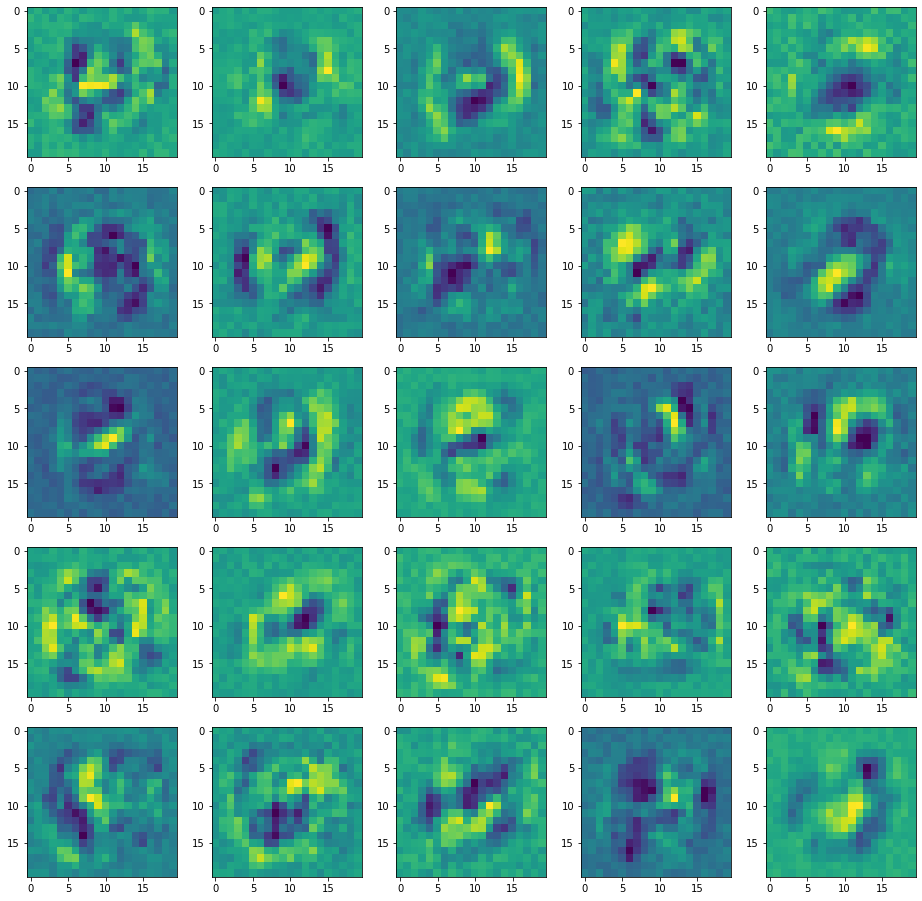

In [11]:
# show the weights of each pixel that point to each hidden unit 
fig, ax = plt.subplots(5, 5, figsize=(16,16))
r = 0
for i in range(5):
    for j in range(5):
        ax[i][j].imshow(learned_theta_1[r][1:].reshape(20, 20))
        r += 1
fig.show()

## 3.1 Optional (ungraded) exercise

In [12]:
lamdas = [0, 1, 2, 4, 8, 16]
max_iters = [25, 50, 100]

# try out different lamda and max_iter, compare the results
# time-consuming
for lamda in lamdas:
    for max_iter in max_iters:
        res = opt.minimize(fun=unrolled_nnCostFunction, x0=init_theta_unrolled, args=(theta_1.shape, theta_2.shape, lamda, X, Y), method='TNC', jac=unrolled_gradient, options={'maxiter': max_iter})
        learned_theta_unrolled = res.x
        learned_theta_1 = learned_theta_unrolled[:(theta_1.shape[0] * theta_1.shape[1])].reshape(theta_1.shape)
        learned_theta_2 = learned_theta_unrolled[(theta_1.shape[0] * theta_1.shape[1]):].reshape(theta_2.shape)
        neural_pred = predict(learned_theta_1, learned_theta_2, X_slice)
        neural_accuracy = np.sum(np.argmax(neural_pred, axis = 1) == np.argmax(Y_slice, axis = 1)) / Y_slice.shape[0]
        print("lamda: {}".format(lamda))
        print("max_iter: {}".format(max_iter))
        print("neural_accuracy: {}".format(neural_accuracy))

lamda: 0
max_iter: 25
neural_accuracy: 0.76
lamda: 0
max_iter: 50
neural_accuracy: 0.92
lamda: 0
max_iter: 100
neural_accuracy: 0.96
lamda: 1
max_iter: 25
neural_accuracy: 0.76
lamda: 1
max_iter: 50
neural_accuracy: 0.88
lamda: 1
max_iter: 100
neural_accuracy: 0.96
lamda: 2
max_iter: 25
neural_accuracy: 0.76
lamda: 2
max_iter: 50
neural_accuracy: 0.88
lamda: 2
max_iter: 100
neural_accuracy: 0.96
lamda: 4
max_iter: 25
neural_accuracy: 0.8
lamda: 4
max_iter: 50
neural_accuracy: 0.88
lamda: 4
max_iter: 100
neural_accuracy: 0.92
lamda: 8
max_iter: 25
neural_accuracy: 0.8
lamda: 8
max_iter: 50
neural_accuracy: 0.88
lamda: 8
max_iter: 100
neural_accuracy: 0.88
lamda: 16
max_iter: 25
neural_accuracy: 0.84
lamda: 16
max_iter: 50
neural_accuracy: 0.8
lamda: 16
max_iter: 100
neural_accuracy: 0.92
